In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd drive/MyDrive/Colab_Notebooks/Image_Classification/Covid19-dataset

[Errno 2] No such file or directory: 'drive/MyDrive/Colab_Notebooks/Image_Classification/Covid19-dataset'
/content/drive/MyDrive/Colab_Notebooks/Image_Classification/Covid19-dataset


Import necessary imports

In [117]:
import cv2
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import random

Function to return label given a file location

In [118]:
def get_label_from_path(path):
  if "Covid" in path:
    return "Covid"
  elif "Normal" in path:
    return "Normal"
  elif "Viral_Pneumonia" in path:
    return "Viral_Pneumonia"
  else:
    raise Exception("Path does not contain a valid feature label")

Function to read images from a folder given a path and resize them

In [133]:
def collect_images(path, total_features, total_labels):
  temp_files = []
  [temp_files.extend(glob.glob(path + '*.' + e)) for e in ext]
  temp_images = [cv2.imread(file) for file in temp_files]
  resized_images = []
  for image in temp_images:
    resized_images.append(cv2.resize(image, (100, 100)))
    total_labels.append(get_label_from_path(path))
  total_features.extend(resized_images)
  # print("Temp images: ", len(resized_images))
  # print("Total size: ", len(total_set))

Use the collect_images function to get all training images and test images

In [154]:
train_paths = ["train/Covid/", "train/Normal/", "train/Viral_Pneumonia/"]
test_paths = ["test/Covid/", "test/Normal/", "test/Viral_Pneumonia/"]
ext = ['png', 'jpg', 'jpeg']    # Add image formats here
all_images = []
all_labels = []

for path in train_paths:
  collect_images(path, all_images, all_labels)
for path in test_paths:
  collect_images(path, all_images, all_labels)

# After collecting all images, randomize them
temp_arr = []
for i in range(len(all_images)):
  temp_arr.append((all_images[i], all_labels[i]))
random.shuffle(temp_arr)
for i in range(len(all_images)):
  all_images[i] = temp_arr[i][0]
  all_labels[i] = temp_arr[i][1]
# for path in test_paths:
#   collect_images(path, test_images, test_labels)
FIFTH_OF_DATA = int(0.2 * len(all_images))
train_images = all_images[: 4 * FIFTH_OF_DATA]
train_labels = all_labels[: 4 * FIFTH_OF_DATA]
test_images = all_images[4 * FIFTH_OF_DATA:]
test_labels = all_labels[4 * FIFTH_OF_DATA:]

Ensure that the dimensions of each image are 300x300

In [155]:
def print_dimensions(images):
  average_x = 0
  average_y = 0
  min_x = 1000000
  min_y = 1000000
  train_len = len(images)
  for image in images:
    dimension = image.shape
    average_x += dimension[0]
    min_x = min(min_x, dimension[0])
    if(len(dimension) > 1):
      average_y += dimension[1]
      min_y = min(min_y, dimension[1])
  print("Average width: ", average_x / train_len)
  print("Min width: ", min_x)
  if(len(dimension) > 1):
    print("Average height: ", average_y / train_len)
    print("Min height: ", min_y, "\n")

In [156]:
print("Train image information: ")
print_dimensions(train_images)
# print("Test image information: ")
# print_dimensions(test_images)

Train image information: 
Average width:  100.0
Min width:  100
Average height:  100.0
Min height:  100 



Try visualizing a few of the training images to see what the computer would see

<class 'numpy.ndarray'>


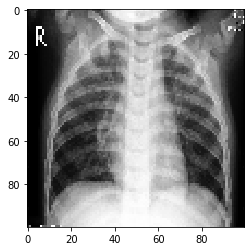

<class 'numpy.ndarray'>


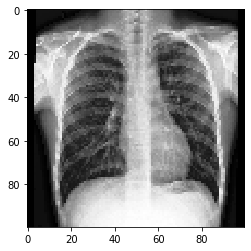

<class 'numpy.ndarray'>


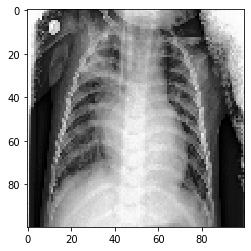

In [157]:
for i in range(3):
  random_img = random.choice(train_images)
  print(type(random_img))
  plt.imshow(random_img, interpolation='nearest')
  plt.show()

Flatten collection of np arrays into 1d arrays

In [165]:
def flatten_images(images):
  for i in range(len(images)):
    images[i] = np.reshape(images[i], -1)

Try classifying the images using an SVC classifier. We first train the classifier using the training set, with a partition of 0.8-0.2. Then, we print out the accuracy the model created has on the holdout.

In [166]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

flatten_images(train_images)
flatten_images(test_images)
flatten_images(all_images)

scaler = StandardScaler()
pca = PCA()
svc_classifier = SVC()
svc_pipeline = Pipeline(steps = [('scaler', scaler), 
                                 ('pca', pca), 
                                 ('svc', svc_classifier)])

svc_param_grid = {
    'pca__n_components': list(range(5, 19)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

svc_classifier.fit(train_images, train_labels)
predictions = svc_classifier.predict(test_images)
print("Accuracy with holdout: ", 
      accuracy_score(test_labels, predictions))
# Create the inner cross-validation loop with a cv = 5
inner_svm = GridSearchCV(svc_pipeline, svc_param_grid, cv = 5)
# Run outer cross-validation loop with cv = 5
fold_accuracies = cross_val_score(inner_svm, 
                                  all_images, 
                                  all_labels, 
                                  cv = 5)
print("Svc accuracy: ", sum(fold_accuracies) / len(fold_accuracies))

Accuracy with holdout:  0.9538461538461539
Svc accuracy:  0.9243551587301587


In [ ]:
import pickle 

final_svc = GridSearchCV(svc_pipeline, svc_param_grid, cv = 5)
final_svc.fit(all_images, all_labels)

print("Best_params: ", final_svc.best_params_)
print("Accuracy: ", final_svc.best_score_)
filename = 'final_svc_model.sav'
# pickle.dump(filename, open(filename, 'wb'))